In [1]:
save_file = 'version2_leak'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn import metrics, base
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import mean_squared_error
import datetime
import gc
from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm_notebook
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype
from meteocalc import Temp, dew_point, heat_index, wind_chill, feels_like
import warnings
warnings.filterwarnings('ignore')
DATA_PATH = "../"

In [3]:
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
building = pd.read_csv(DATA_PATH + 'building_metadata.csv')
building = reduce_mem_usage(building,use_float16=True)

Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.8%


In [5]:
leak_df = pd.read_feather('leak.feather')
leak_df.fillna(0, inplace=True)
leak_df = leak_df[(leak_df.timestamp.dt.year > 2016) & (leak_df.timestamp.dt.year < 2019)]
leak_df.loc[leak_df.meter_reading < 0, 'meter_reading'] = 0 # remove large negative values
leak_df = leak_df[leak_df.building_id!=245]
leak_df['timestamp'] = leak_df['timestamp'].astype(str)

In [6]:
train = pd.read_csv(DATA_PATH + 'train.csv')
train = reduce_mem_usage(train,use_float16=True)
bad_rows = pd.read_csv(DATA_PATH + 'rows_to_drop.csv')
train = train.drop(index=bad_rows['0'].values)
train = pd.concat([train, leak_df]).reset_index(drop = True)
train = train.merge(building, left_on='building_id',right_on='building_id',how='left')
train.loc[(train['meter'] == 0) & (train['site_id'] == 0), 'meter_reading'] = train['meter_reading'] * 0.2931
del leak_df
gc.collect()

Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.90 MB
Decreased by 71.8%


35

## Utility Functions

In [7]:
def fill_weather_dataset(weather):

    zone_dict={0:4,1:0,2:7,3:4,4:7,5:0,6:4,7:4,8:4,9:5,10:7,11:4,12:0,13:5,14:4,15:4} 

    def set_localtime(df):
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        for sid, zone in zone_dict.items():
            sids = df.site_id == sid
            df.loc[sids, 'timestamp'] = df[sids].timestamp - pd.offsets.Hour(zone)
        df['timestamp'] = df['timestamp'].dt.strftime("%Y-%m-%d %H:%M:%S")
    
    set_localtime(weather)
    
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    missing_hours = []
    for site_id in range(16):
        site_hours = np.array(weather[weather['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather = pd.concat([weather,new_rows])

        weather = weather.reset_index(drop=True)           

    # Add new Features
    weather["datetime"] = pd.to_datetime(weather["timestamp"])
    weather["day"] = weather["datetime"].dt.day
    weather["week"] = weather["datetime"].dt.week
    weather["month"] = weather["datetime"].dt.month
    
    # Reset Index for Fast Update
    weather = weather.set_index(['site_id','day','month'])

    air_temperature_filler = pd.DataFrame(weather.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather.update(air_temperature_filler,overwrite=False)

    cloud_coverage_filler = weather.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])
    weather.update(cloud_coverage_filler,overwrite=False)

    due_temperature_filler = pd.DataFrame(weather.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather.update(due_temperature_filler,overwrite=False)

    sea_level_filler = weather.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])
    weather.update(sea_level_filler,overwrite=False)

    wind_direction_filler =  pd.DataFrame(weather.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    weather.update(wind_direction_filler,overwrite=False)
    
    wind_speed_filler =  pd.DataFrame(weather.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather.update(wind_speed_filler,overwrite=False)

    precip_depth_filler = weather.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])
    weather.update(precip_depth_filler,overwrite=False)

    weather = weather.reset_index()
    weather = weather.drop(['datetime','day','week','month'],axis=1)
    
    weather.loc[weather['dew_temperature'] > weather['air_temperature'], 'dew_temperature'] = weather['air_temperature']
    weather['humidity'] = 100*(np.exp((17.625*weather['dew_temperature'])/(243.04+weather['dew_temperature']))/np.exp((17.625*weather['air_temperature'])/(243.04+weather['air_temperature'])))
    
    weather['heat_index'] = weather.apply(lambda x: heat_index(temperature=x['air_temperature'], humidity=x['humidity']), axis=1)
    weather['heat_index'] = weather['heat_index'].apply(lambda x: round(x, 2))
    weather['feels_like'] = weather.apply(lambda x: feels_like(temperature=x['air_temperature'], humidity=x['humidity'], wind_speed=x['wind_speed']), axis=1)
    weather['feels_like'] = weather['feels_like'].apply(lambda x: round(x, 2))
    
    return weather

In [8]:
def set_holiday2(dataframe):
    # site 0
    date1 = pd.date_range(start='1/1/2016',end='1/05/2016')
    date2 = pd.date_range(start='3/21/2016', end='3/27/2016')
    date3 = pd.date_range(start='11/24/2016', end='11/25/2016')
    date4 = pd.date_range(start='12/19/2016',end='12/31/2016')
    date5 = pd.date_range(start='1/1/2017', end='1/08/2017')
    date6 = pd.date_range(start='3/13/2017', end='3/17/2017')
    date7 = pd.date_range(start='11/23/2017', end='11/24/2017')
    date8 = pd.date_range(start='12/19/2017',end='12/31/2017')
    date9 = pd.date_range(start='1/1/2018', end='1/07/2018')
    date10 = pd.date_range(start='3/12/2018', end='3/18/2018')
    date11 = pd.date_range(start='11/22/2018', end='11/23/2018')
    date12 = pd.date_range(start='12/19/2018',end='12/31/2018')
    site0_hol = date1.union(date2).union(date3).union(date4).union(date5).union(date6).union(date7).union(date8).union(date9).union(date10).union(date11).union(date12)
    sids = dataframe.site_id == 0
    dataframe.loc[(sids) & (dataframe.timestamp.isin((site0_hol))), 'is_holiday'] = 1
    # site 1
    date1 = pd.date_range(start='1/1/2016',end='1/03/2016')
    date2 = pd.date_range(start='3/25/2016', end='3/30/2016')
    date3 = pd.date_range(start='12/24/2016',end='12/31/2016')
    date4 = pd.date_range(start='1/1/2017', end='1/02/2017')
    date5 = pd.date_range(start='3/13/2017', end='3/19/2017')
    date6 = pd.date_range(start='12/23/2017',end='12/31/2017')
    date7 = pd.date_range(start='3/29/2018', end='4/04/2018')
    date8 = pd.date_range(start='12/22/2018',end='12/31/2018')
    site1_hol = date1.union(date2).union(date3).union(date4).union(date5).union(date6).union(date7).union(date8)
    sids = dataframe.site_id == 1
    dataframe.loc[(sids) & (dataframe.timestamp.isin((site1_hol))), 'is_holiday'] = 1
    # site 2
    date1 = pd.date_range(start='1/1/2016',end='1/12/2016')
    date2 = pd.date_range(start='3/12/2016', end='3/20/2016')
    date3 = pd.date_range(start='11/24/2016', end='11/27/2016')
    date4 = pd.date_range(start='12/26/2016',end='12/27/2016')
    date5 = pd.date_range(start='1/1/2017', end='1/9/2017')
    date6 = pd.date_range(start='3/11/2017', end='3/19/2017')
    date7 = pd.date_range(start='11/23/2017', end='11/26/2017')
    date8 = pd.date_range(start='12/25/2017',end='12/26/2017')
    date9 = pd.date_range(start='1/1/2018', end='1/09/2018')
    date10 = pd.date_range(start='3/5/2018', end='3/9/2018')
    date11 = pd.date_range(start='11/22/2018', end='11/25/2018')
    date12 = pd.date_range(start='12/24/2018',end='12/25/2018')
    site2_hol = date1.union(date2).union(date3).union(date4).union(date5).union(date6).union(date7).union(date8).union(date9).union(date10).union(date11).union(date12)
    sids = dataframe.site_id == 2
    dataframe.loc[(sids) & (dataframe.timestamp.isin((site2_hol))), 'is_holiday'] = 1
    # site 4
    date1 = pd.date_range(start='1/1/2016',end='1/11/2016')
    date2 = pd.date_range(start='3/21/2016', end='3/25/2016')
    date3 = pd.date_range(start='11/24/2016', end='11/25/2016')
    date4 = pd.date_range(start='12/26/2016',end='12/27/2016')
    date5 = pd.date_range(start='1/1/2017', end='1/9/2017')
    date6 = pd.date_range(start='3/27/2017', end='3/31/2017')
    date7 = pd.date_range(start='11/23/2017', end='11/26/2017')
    date8 = pd.date_range(start='12/25/2017',end='12/26/2017')
    date9 = pd.date_range(start='12/29/2017',end='12/29/2017')
    date10 = pd.date_range(start='1/1/2018', end='1/08/2018')
    date11 = pd.date_range(start='3/26/2018', end='3/30/2018')
    date12 = pd.date_range(start='11/22/2018', end='11/23/2018')
    date13 = pd.date_range(start='12/24/2018',end='12/25/2018')
    date14 = pd.date_range(start='12/31/2018',end='12/31/2018')
    site4_hol = date1.union(date2).union(date3).union(date4).union(date5).union(date6).union(date7).union(date8).union(date9).union(date10).union(date11).union(date12).union(date13).union(date14)
    sids = dataframe.site_id == 4
    dataframe.loc[(sids) & (dataframe.timestamp.isin((site4_hol))), 'is_holiday'] = 1
    # site 5
    date1 = pd.date_range(start='1/1/2016',end='1/3/2016')
    date2 = pd.date_range(start='3/19/2016', end='4/17/2016')
    date3 = pd.date_range(start='6/11/2016', end='8/21/2016')
    date4 = pd.date_range(start='1/1/2017',end='1/8/2017')
    date5 = pd.date_range(start='3/23/2017', end='4/23/2017')
    date6 = pd.date_range(start='6/17/2017', end='8/20/2017')
    date7 = pd.date_range(start='1/1/2018',end='1/7/2018')
    date8 = pd.date_range(start='3/17/2018', end='4/15/2018')
    date9 = pd.date_range(start='6/16/2018', end='8/19/2018')
    site5_hol = date1.union(date2).union(date3).union(date4).union(date5).union(date6).union(date7).union(date8).union(date9)
    sids = dataframe.site_id == 5
    dataframe.loc[(sids) & (dataframe.timestamp.isin((site5_hol))), 'is_holiday'] = 1
    # site 7&11
    date1 = pd.date_range(start='1/1/2016',end='1/06/2016')
    date2 = pd.date_range(start='2/29/2016', end='3/4/2016')
    date3 = pd.date_range(start='11/24/2016', end='11/25/2016')
    date4 = pd.date_range(start='12/23/2016',end='12/31/2016')
    date5 = pd.date_range(start='1/1/2017', end='1/03/2017')
    date6 = pd.date_range(start='2/27/2017', end='3/3/2017')
    date7 = pd.date_range(start='11/23/2017', end='11/24/2017')
    date8 = pd.date_range(start='12/23/2017',end='12/31/2017')
    date9 = pd.date_range(start='1/1/2018', end='1/07/2018')
    date10 = pd.date_range(start='3/5/2018', end='3/9/2018')
    date11 = pd.date_range(start='11/22/2018', end='11/23/2018')
    date12 = pd.date_range(start='12/24/2018',end='12/31/2018')
    site_hol = date1.union(date2).union(date3).union(date4).union(date5).union(date6).union(date7).union(date8).union(date9).union(date10).union(date11).union(date12)
    sids = dataframe.site_id == 7
    dataframe.loc[(sids) & (dataframe.timestamp.isin((site_hol))), 'is_holiday'] = 1
    sids = dataframe.site_id == 11
    dataframe.loc[(sids) & (dataframe.timestamp.isin((site_hol))), 'is_holiday'] = 1
    # site 9
    date1 = pd.date_range(start='1/1/2016',end='1/06/2016')
    date2 = pd.date_range(start='3/14/2016', end='3/19/2016')
    date3 = pd.date_range(start='11/23/2016', end='11/26/2016')
    date4 = pd.date_range(start='12/23/2016',end='12/31/2016')
    date5 = pd.date_range(start='1/1/2017', end='1/04/2017')
    date6 = pd.date_range(start='3/13/2017', end='3/18/2017')
    date7 = pd.date_range(start='11/22/2017', end='11/25/2017')
    date8 = pd.date_range(start='12/23/2017',end='12/31/2017')
    date9 = pd.date_range(start='1/1/2018', end='1/03/2018')
    date10 = pd.date_range(start='3/12/2018', end='3/17/2018')
    date11 = pd.date_range(start='11/21/2018', end='11/24/2018')
    date12 = pd.date_range(start='12/24/2018',end='12/31/2018')
    site9_hol = date1.union(date2).union(date3).union(date4).union(date5).union(date6).union(date7).union(date8).union(date9).union(date10).union(date11).union(date12)
    sids = dataframe.site_id == 9
    dataframe.loc[(sids) & (dataframe.timestamp.isin((site9_hol))), 'is_holiday'] = 1
    # site 10
    date1 = pd.date_range(start='1/1/2016',end='1/10/2016')
    date2 = pd.date_range(start='3/5/2016', end='3/13/2016')
    date3 = pd.date_range(start='11/24/2016', end='11/25/2016')
    date4 = pd.date_range(start='12/23/2016',end='12/31/2016')
    date5 = pd.date_range(start='1/1/2017', end='1/08/2017')
    date6 = pd.date_range(start='3/4/2017', end='3/12/2017')
    date7 = pd.date_range(start='11/23/2017', end='11/24/2017')
    date8 = pd.date_range(start='12/24/2017',end='12/31/2017')
    date9 = pd.date_range(start='1/1/2018', end='1/07/2018')
    date10 = pd.date_range(start='3/3/2018', end='3/11/2018')
    date11 = pd.date_range(start='11/22/2018', end='11/23/2018')
    date12 = pd.date_range(start='12/24/2018',end='12/31/2018')
    site10_hol = date1.union(date2).union(date3).union(date4).union(date5).union(date6).union(date7).union(date8).union(date9).union(date10).union(date11).union(date12)
    sids = dataframe.site_id == 10
    dataframe.loc[(sids) & (dataframe.timestamp.isin((site10_hol))), 'is_holiday'] = 1
    # site 13
    date1 = pd.date_range(start='1/1/2016',end='1/12/2016')
    date2 = pd.date_range(start='3/7/2016', end='3/11/2016')
    date3 = pd.date_range(start='10/27/2016', end='10/28/2016')
    date4 = pd.date_range(start='11/24/2016', end='11/25/2016')
    date5 = pd.date_range(start='12/23/2016',end='12/30/2016')
    date6 = pd.date_range(start='1/1/2017',end='1/10/2017')
    date7 = pd.date_range(start='3/6/2017', end='3/10/2017')
    date8 = pd.date_range(start='10/26/2017', end='10/27/2017')
    date9 = pd.date_range(start='11/23/2017', end='11/24/2017')
    date10 = pd.date_range(start='12/25/2017',end='12/29/2017')
    date11 = pd.date_range(start='1/1/2018',end='1/9/2018')
    date12 = pd.date_range(start='3/5/2018', end='3/9/2018')
    date13 = pd.date_range(start='10/25/2018', end='10/26/2018')
    date14 = pd.date_range(start='11/22/2018', end='11/23/2018')
    date15 = pd.date_range(start='12/25/2018',end='12/26/2018')
    date16 = pd.date_range(start='12/31/2018',end='12/31/2018')
    site13_hol = date1.union(date2).union(date3).union(date4).union(date5).union(date6).union(date7).union(date8).union(date9).union(date10).union(date11).union(date12).union(date13).union(date14).union(date15).union(date16)
    sids = dataframe.site_id == 13
    dataframe.loc[(sids) & (dataframe.timestamp.isin((site13_hol))), 'is_holiday'] = 1
    # site 14
    date1 = pd.date_range(start='1/1/2016',end='1/03/2016')
    date2 = pd.date_range(start='3/5/2016', end='3/13/2016')
    date3 = pd.date_range(start='11/23/2016', end='11/27/2016')
    date4 = pd.date_range(start='1/1/2017', end='1/02/2017')
    date5 = pd.date_range(start='3/4/2017', end='3/12/2017')
    date6 = pd.date_range(start='11/22/2017', end='11/26/2017')
    date7 = pd.date_range(start='1/1/2018', end='1/02/2018')
    date8 = pd.date_range(start='3/3/2018', end='3/11/2018')
    date9 = pd.date_range(start='11/21/2018', end='11/25/2018')
    site14_hol = date1.union(date2).union(date3).union(date4).union(date5).union(date6).union(date7).union(date8).union(date9)
    sids = dataframe.site_id == 14
    dataframe.loc[(sids) & (dataframe.timestamp.isin((site14_hol))), 'is_holiday'] = 1
    # site 15
    date1 = pd.date_range(start='1/1/2016',end='1/03/2016')
    date2 = pd.date_range(start='2/13/2016',end='2/17/2016')
    date3 = pd.date_range(start='3/26/2016', end='4/3/2016')
    date4 = pd.date_range(start='10/8/2016', end='10/11/2016')
    date5 = pd.date_range(start='11/23/2016', end='11/27/2016')
    date6 = pd.date_range(start='12/26/2016',end='12/31/2016')
    date7 = pd.date_range(start='1/1/2017',end='1/02/2017')
    date8 = pd.date_range(start='2/18/2017',end='2/21/2017')
    date9 = pd.date_range(start='4/1/2017', end='4/9/2017')
    date10 = pd.date_range(start='10/7/2017', end='10/10/2017')
    date11 = pd.date_range(start='11/22/2017', end='11/26/2017')
    date12 = pd.date_range(start='12/25/2017',end='12/31/2017')
    date13 = pd.date_range(start='2/17/2018',end='2/20/2018')
    date14 = pd.date_range(start='3/31/2018', end='4/8/2018')
    date15 = pd.date_range(start='10/6/2018', end='10/9/2018')
    date16 = pd.date_range(start='11/21/2018', end='11/25/2018')
    date17 = pd.date_range(start='12/24/2018',end='12/31/2018')
    site15_hol = date1.union(date2).union(date3).union(date4).union(date5).union(date6).union(date7).union(date8).union(date9).union(date10).union(date11).union(date12).union(date13).union(date14).union(date15).union(date16).union(date17)
    sids = dataframe.site_id == 15
    dataframe.loc[(sids) & (dataframe.timestamp.isin((site15_hol))), 'is_holiday'] = 1
    return dataframe

In [9]:
def features_engineering(df):
    
    # Sort by timestamp
    df.sort_values("timestamp")
    df.reset_index(drop=True)
    
    # Add more features
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    df["hour"] = df["timestamp"].dt.hour
    df["dayofweek"] = df["timestamp"].dt.weekday
    
    df['month'] = df['timestamp'].dt.month
    df['month'].replace((1, 2, 3, 12), 1, inplace = True)
    df['month'].replace((6, 7, 8, 9), 3, inplace = True)
    df['month'].replace((10, 11, 4, 5), 2, inplace = True)
    
    us_holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                  "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                  "2017-01-02", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                  "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                  "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                  "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                  "2019-01-01"]
    uk_holidays = ["2016-01-01", "2016-01-02", "2016-03-25", "2016-03-28", "2016-05-02", 
                   "2016-05-30", "2016-08-29", "2016-12-25", "2016-12-26", "2016-12-27", 
                   "2017-01-01", "2017-01-02", "2017-04-14", "2017-04-17", "2017-05-01", 
                   "2017-05-29", "2017-08-28", "2017-12-25", "2017-12-26", 
                   "2018-01-01", "2018-01-02", "2018-03-30", "2018-04-02", "2018-05-07", 
                   "2018-05-28", "2018-08-27", "2018-12-25", "2018-12-26",
                   "2019-01-01"]
    ir_holidays = ["2016-01-01", "2016-01-02", "2016-03-17", "2016-03-28", "2016-05-02", 
                   "2016-06-02", "2016-08-01", "2016-10-31", "2016-12-26", "2016-12-27", 
                   "2017-01-01", "2017-01-02", "2017-03-17", "2017-04-14", "2017-05-01", 
                   "2017-06-05", "2017-08-07", "2017-10-30", "2017-12-25", "2017-12-26", 
                   "2018-01-01", "2018-01-02", "2018-03-19", "2018-04-02", "2018-05-07", 
                   "2018-06-04", "2018-08-06", "2018-10-29", "2018-12-25", "2018-12-26",
                   "2019-01-01"]

    def set_holiday():
        df["is_holiday"] = 0
        df.loc[df.dayofweek.isin([5,6]), 'is_holiday'] = 1
        us_zone = [0,2,3,4,6,7,8,9,10,11,13,14,15]
        for sid in us_zone:
            sids = df.site_id == sid
            df.loc[(sids) & (df.timestamp.isin(pd.to_datetime(us_holidays))), 'is_holiday'] = 1
        uk_zone = [1,5]
        for sid in uk_zone:
            sids = df.site_id == sid
            df.loc[(sids) & (df.timestamp.isin(pd.to_datetime(uk_holidays))), 'is_holiday'] = 1
        sids = df.site_id == 12
        df.loc[(sids) & (df.timestamp.isin(pd.to_datetime(ir_holidays))), 'is_holiday'] = 1
        return df
    
    df = set_holiday()
    df = set_holiday2(df)
    df['square_feet'] =  np.log1p(df['square_feet'])
    
    # Remove Unused Columns
    drop = ["timestamp","sea_level_pressure","wind_direction","wind_speed","year_built","floor_count"]
    df = df.drop(drop, axis=1)
    gc.collect()
    return df

## Fill Weather Information

I'm using [this kernel](https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling) to handle missing weather information.

In [10]:
weather_train = pd.read_csv(DATA_PATH + 'weather_train.csv')
weather_train = fill_weather_dataset(weather_train)
weather_train = reduce_mem_usage(weather_train,use_float16=True)

Memory usage of dataframe is 12.88 MB
Memory usage after optimization is: 3.46 MB
Decreased by 73.1%


In [11]:
def create_lag_features(df, window):
    df['ave_temp'] = df['air_temperature']/2 + df['dew_temperature']/2
    
    feature_cols = ["air_temperature", "dew_temperature", "cloud_coverage", "precip_depth_1_hr","ave_temp",
                    "humidity",'heat_index']
    df_site = df.groupby("site_id")

    df_rolled = df_site[feature_cols].rolling(window=window, min_periods=0)

    df_mean = df_rolled.mean().reset_index().astype(np.float16)
    df_min = df_rolled.min().reset_index().astype(np.float16)
    df_std = df_rolled.std().reset_index().astype(np.float16)

    for feature in feature_cols:
        df[f"{feature}_mean_lag{window}"] = df_mean[feature]
        df[f"{feature}_min_lag{window}"] = df_min[feature]
        df[f"{feature}_std_lag{window}"] = df_std[feature]
    
    if window == 6:
        for feature in feature_cols:
            df[f"{feature}_diff1"] = df[feature].diff(1)
        
    return df

weather_train = create_lag_features(weather_train, 3)
weather_train = create_lag_features(weather_train, 6)

## Merge Data


In [12]:
weather_test = pd.read_csv(DATA_PATH + 'weather_test.csv')
weather_test = fill_weather_dataset(weather_test)
weather_test = reduce_mem_usage(weather_test, use_float16 = True)
weather_test = create_lag_features(weather_test, 3)
weather_test = create_lag_features(weather_test, 6)
weather = pd.concat([weather_train, weather_test])
train = train.merge(weather,how='left',left_on=['site_id','timestamp'],right_on=['site_id','timestamp'])
del weather, weather_train, weather_test
gc.collect()

Memory usage of dataframe is 25.67 MB
Memory usage after optimization is: 6.91 MB
Decreased by 73.1%


0

## Features Engineering

In [13]:
train = features_engineering(train)

meter_encodage={0:0,3:1,1:2,2:3}
train['meter']=[meter_encodage[c] for c in train['meter']]
encodage={'Religious worship':1,'Warehouse/storage':2,'Technology/science':3,'Other':4,'Retail':5,'Parking':6,\
         'Lodging/residential':7,'Manufacturing/industrial':8,'Public services':9,'Food sales and service':10,\
         'Entertainment/public assembly':11,'Utility':12,'Office':13,'Healthcare':14,'Services':15,\
         'Education':16}
train['primary_use']=[encodage[c] for c in train['primary_use']]
train["puse_hour"] = train["primary_use"].astype(str) + '_' + train["hour"].astype(str)
train["holiday_hour"] = train["is_holiday"].astype(str) + '_' + train["hour"].astype(str)

In [14]:
def generate_categorical_encoders(train, features):
    encoders = {}
    for feature in features:
        train[feature] = train[feature].fillna('missing')
        encoder = LabelEncoder()
        encoder.fit(train[feature].values)
        le_dict = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
        encoders[feature] = le_dict
    return encoders

def encode_categorical_features(df, features, encoders):
    for f in features:
        df[f] = df[f].fillna('missing')
        df[f] = df[f].map(encoders[f])

encoded_features = ["puse_hour","holiday_hour"] 
encoders = generate_categorical_encoders(train, encoded_features)
encode_categorical_features(train, encoded_features, encoders)

## Features & Target Variables

In [15]:
target = np.log1p(train["meter_reading"])
features = train.drop('meter_reading', axis = 1)
features = reduce_mem_usage(features,use_float16=True)
del bad_rows, train
gc.collect()

Memory usage of dataframe is 6060.69 MB
Memory usage after optimization is: 4060.36 MB
Decreased by 33.0%


0

##  KFOLD LIGHTGBM Model

In [16]:
categorical_features = ["meter","primary_use","building_id","site_id","dayofweek","hour","puse_hour","holiday_hour"] 

params = {
    'max_depth': 12,
    'min_data_in_leaf': 220,    
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1280,
    "learning_rate": 0.03,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
    "max_bin": 320,
    "random_state":42
}
folds = 5
kf = KFold(n_splits=folds)
models = []

for fold_, (trn_idx, val_idx) in enumerate(kf.split(features,features['month'])):  #
    print("fold {}".format(fold_))
    train_features = features.loc[trn_idx]
    train_target = target.loc[trn_idx]
    
    test_features = features.loc[val_idx]
    test_target = target.loc[val_idx]
    
    d_training = lgb.Dataset(train_features, label=train_target,categorical_feature=categorical_features, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target,categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=10000, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
    models.append(model)
    
    del train_features, train_target, test_features, test_target, d_training, d_test, model
    gc.collect()

fold 0
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.30277	valid_1's rmse: 1.37686
[50]	training's rmse: 1.0263	valid_1's rmse: 1.12076
[75]	training's rmse: 0.876788	valid_1's rmse: 0.983682
[100]	training's rmse: 0.800384	valid_1's rmse: 0.91998
[125]	training's rmse: 0.746462	valid_1's rmse: 0.876399
[150]	training's rmse: 0.720288	valid_1's rmse: 0.858386
[175]	training's rmse: 0.704263	valid_1's rmse: 0.849101
[200]	training's rmse: 0.689384	valid_1's rmse: 0.842721
[225]	training's rmse: 0.680047	valid_1's rmse: 0.840206
[250]	training's rmse: 0.671849	valid_1's rmse: 0.837671
[275]	training's rmse: 0.664976	valid_1's rmse: 0.835518
[300]	training's rmse: 0.658977	valid_1's rmse: 0.833912
[325]	training's rmse: 0.652196	valid_1's rmse: 0.833074
[350]	training's rmse: 0.64559	valid_1's rmse: 0.832173
[375]	training's rmse: 0.639276	valid_1's rmse: 0.831429
[400]	training's rmse: 0.633216	valid_1's rmse: 0.830836
[425]	training's rmse: 0.62770

[125]	training's rmse: 0.769374	valid_1's rmse: 0.854932
[150]	training's rmse: 0.740745	valid_1's rmse: 0.836871
[175]	training's rmse: 0.720544	valid_1's rmse: 0.828072
[200]	training's rmse: 0.705222	valid_1's rmse: 0.823891
[225]	training's rmse: 0.693602	valid_1's rmse: 0.82122
[250]	training's rmse: 0.683277	valid_1's rmse: 0.820605
[275]	training's rmse: 0.673757	valid_1's rmse: 0.819425
[300]	training's rmse: 0.667051	valid_1's rmse: 0.819643
Early stopping, best iteration is:
[273]	training's rmse: 0.674288	valid_1's rmse: 0.818995


0.8148248747207326
0.8145549038455192

In [17]:
del features, target
gc.collect()

20

## Important Features

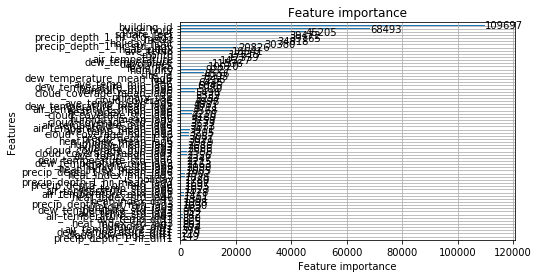

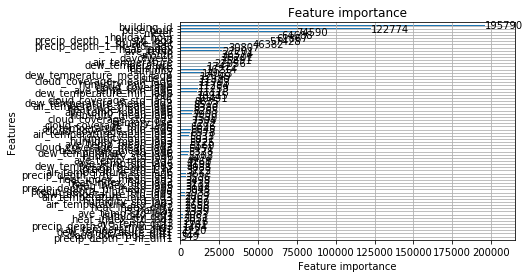

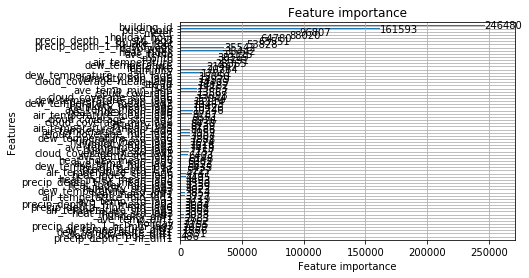

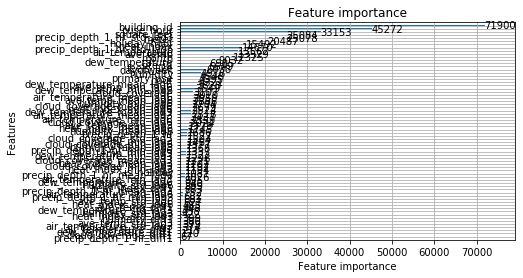

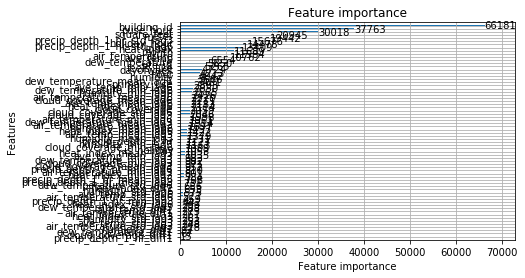

In [18]:
for model in models:
    lgb.plot_importance(model)
    plt.show()

## Prediction

In [19]:
weather = pd.read_csv(DATA_PATH + 'weather_test.csv')
weather = fill_weather_dataset(weather)
weather = reduce_mem_usage(weather, use_float16 = True)
weather = create_lag_features(weather, 3)
weather = create_lag_features(weather, 6)

Memory usage of dataframe is 25.67 MB
Memory usage after optimization is: 6.91 MB
Decreased by 73.1%


In [20]:
test = pd.read_csv(DATA_PATH + 'test.csv')
test = reduce_mem_usage(test, use_float16 = True)

test = test.merge(building,left_on='building_id',right_on='building_id',how='left')
submission = test[["row_id",'meter','site_id']]
test.drop("row_id", axis=1, inplace=True)
test = test.merge(weather,how='left',on=['timestamp','site_id'])

test = features_engineering(test)
test['meter']=[meter_encodage[c] for c in test['meter']]
test['primary_use']=[encodage[c] for c in test['primary_use']]
test["puse_hour"] = test["primary_use"].astype(str) + '_' + test["hour"].astype(str)
test["holiday_hour"] = test["is_holiday"].astype(str) + '_' + test["hour"].astype(str)
encode_categorical_features(test, encoded_features, encoders)
del weather, building
gc.collect()

Memory usage of dataframe is 1272.51 MB
Memory usage after optimization is: 358.65 MB
Decreased by 71.8%


0

In [ ]:
iterations = 100
set_size = len(test)
batch_size = set_size // iterations
meter_reading = []
for i in tqdm(range(iterations)):
    pos = i*batch_size
    fold_preds = [np.expm1(model.predict(test.iloc[pos:pos+batch_size], num_iteration=model.best_iteration)) for model in models]
    meter_reading.extend(np.mean(fold_preds, axis=0))
    del pos, fold_preds

print(len(meter_reading))
assert len(meter_reading) == set_size
del test, models

submission['meter_reading'] = np.clip(meter_reading, a_min=0, a_max=None)
submission.loc[(submission['meter'] == 0) & (submission['site_id'] == 0), 'meter_reading'] = submission['meter_reading'] * 3.4118
submission = submission.drop(['meter','site_id'], axis = 1)
submission.to_csv(f'{save_file}.csv', index=False)


41697600
